# NN by pytorch

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch.utils.tensorboard import SummaryWriter


In [3]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [5]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/NN_tuned_fe")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    extract_pos_s21_offset,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import dict_act, NN_fe, train_NN, count_parameters


## Data Extraction

In [8]:
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [9]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 242)
(411257,)
(102815, 242)
(102815,)


### Normalization

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X)
X_train_scaled = X_scaled[idx_train]
X_test_scaled = X_scaled[idx_test]
X_TEST_scaled = scaler.transform(X_TEST)

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 242)
(411257, 1)
(102815, 242)
(102815, 1)
(20135, 242)
(20135, 1)


## NN

### Init

In [17]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": True,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8659


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [15]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [16]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [17]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:0.4f} seconds")


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.68, test loss : 1031.14, TEST loss : 1026.29, lr: 0.0010
epoch : 10, train loss : 635.26, test loss : 616.98, TEST loss : 612.35, lr: 0.0010
epoch : 20, train loss : 299.93, test loss : 285.55, TEST loss : 281.89, lr: 0.0010
epoch : 30, train loss : 71.60, test loss : 63.41, TEST loss : 60.88, lr: 0.0010
epoch : 40, train loss : 22.07, test loss : 19.78, TEST loss : 17.75, lr: 0.0010
epoch : 50, train loss : 14.74, test loss : 13.92, TEST loss : 13.00, lr: 0.0010
epoch : 60, train loss : 10.00, test loss : 8.35, TEST loss : 8.36, lr: 0.0010
epoch : 70, train loss : 7.18, test loss : 5.44, TEST loss : 6.09, lr: 0.0010
epoch : 80, train loss : 5.99, test loss : 5.22, TEST loss : 5.80, lr: 0.0010
epoch : 90, train loss : 5.36, test loss : 3.22, TEST loss : 3.66, lr: 0.0010
epoch : 100, train loss : 5.08, test loss : 4.79, TEST loss : 5.14, lr: 0.0010
epoch : 110, train loss : 4.79, test loss : 3.68, TEST loss : 4.50, lr: 0.0010
epoch : 120, train loss : 4.60, 

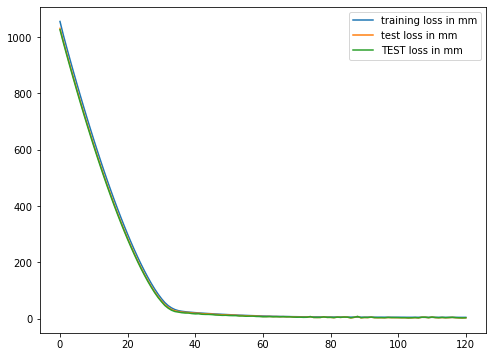

In [17]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [18]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [20]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.28 mm
test RMSE: 2.29 mm
TEST RMSE: 4.03 mm


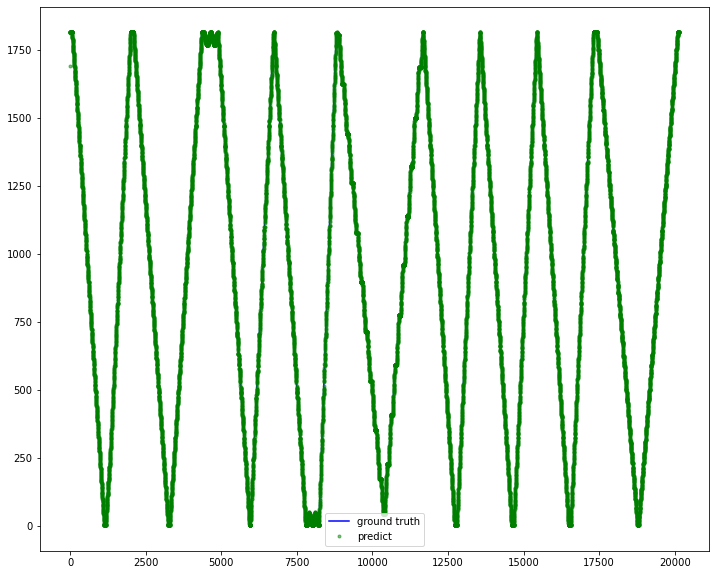

In [20]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


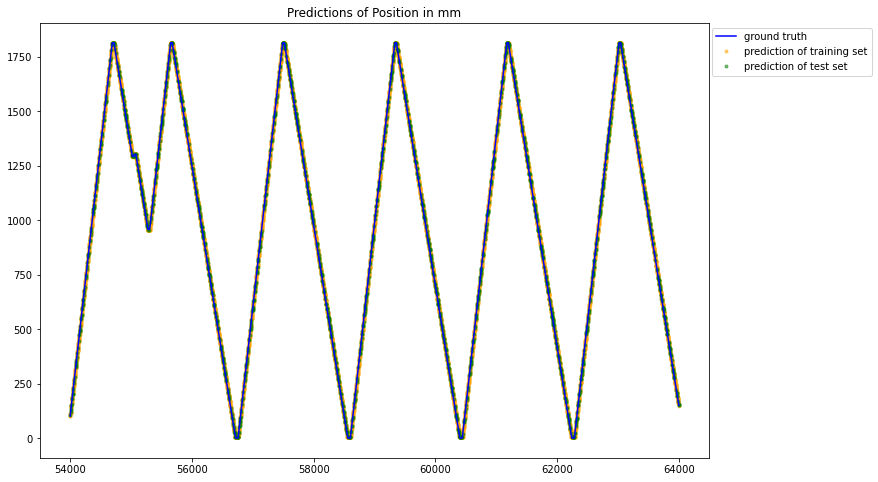

In [21]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## NN without batch norm

### Init

In [17]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8563


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [24]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [25]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [26]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
    
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:0.4f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1059.42, test loss : 1042.60, TEST loss : 1037.71, lr: 0.0010
epoch : 10, train loss : 731.85, test loss : 717.37, TEST loss : 712.58, lr: 0.0010
epoch : 20, train loss : 449.83, test loss : 437.36, TEST loss : 433.22, lr: 0.0010
epoch : 30, train loss : 219.51, test loss : 209.50, TEST loss : 206.35, lr: 0.0010
epoch : 40, train loss : 55.34, test loss : 48.96, TEST loss : 47.28, lr: 0.0010
epoch : 50, train loss : 5.85, test loss : 5.60, TEST loss : 7.42, lr: 0.0010
epoch : 60, train loss : 4.24, test loss : 4.32, TEST loss : 5.62, lr: 0.0010
epoch : 70, train loss : 3.54, test loss : 3.48, TEST loss : 4.76, lr: 0.0010
epoch : 80, train loss : 3.15, test loss : 3.55, TEST loss : 4.55, lr: 0.0010
epoch : 90, train loss : 2.86, test loss : 2.95, TEST loss : 4.05, lr: 0.0010
epoch : 100, train loss : 2.66, test loss : 2.53, TEST loss : 3.51, lr: 0.0010
epoch : 110, train loss : 2.44, test loss : 2.36, TEST loss : 3.62, lr: 0.0010
epoch : 120, train loss : 2.30, t

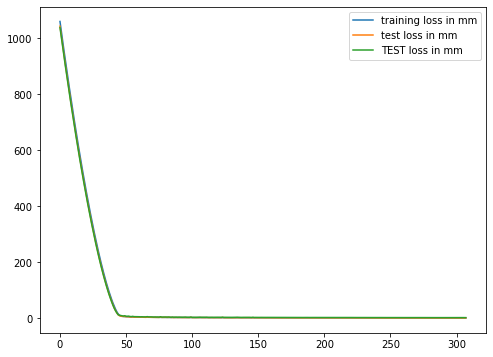

In [27]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [18]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


RuntimeError: Error(s) in loading state_dict for NN_fe:
	Missing key(s) in state_dict: "layers.2.weight", "layers.2.bias". 
	Unexpected key(s) in state_dict: "layers.6.weight", "layers.6.bias", "layers.1.weight", "layers.1.bias", "layers.1.running_mean", "layers.1.running_var", "layers.1.num_batches_tracked", "layers.3.weight", "layers.3.bias", "layers.4.running_mean", "layers.4.running_var", "layers.4.num_batches_tracked". 
	size mismatch for layers.4.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([1, 16]).
	size mismatch for layers.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([1]).

In [16]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [29]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.17 mm
test RMSE: 1.21 mm
TEST RMSE: 2.50 mm


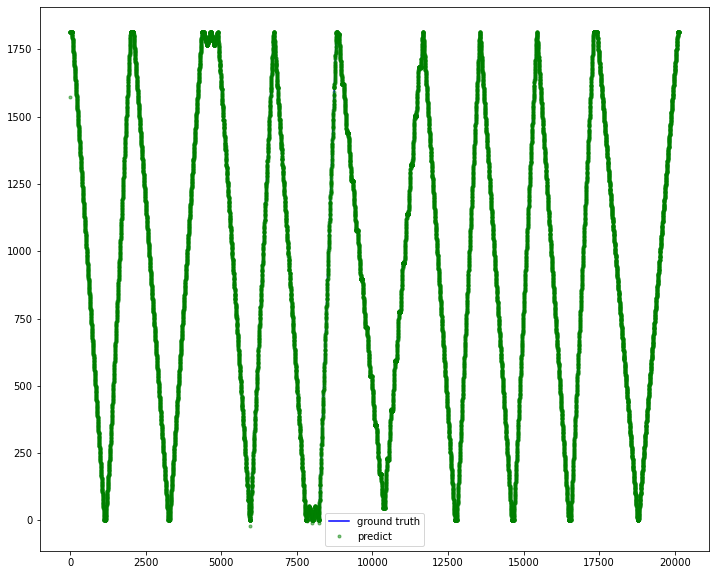

In [30]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


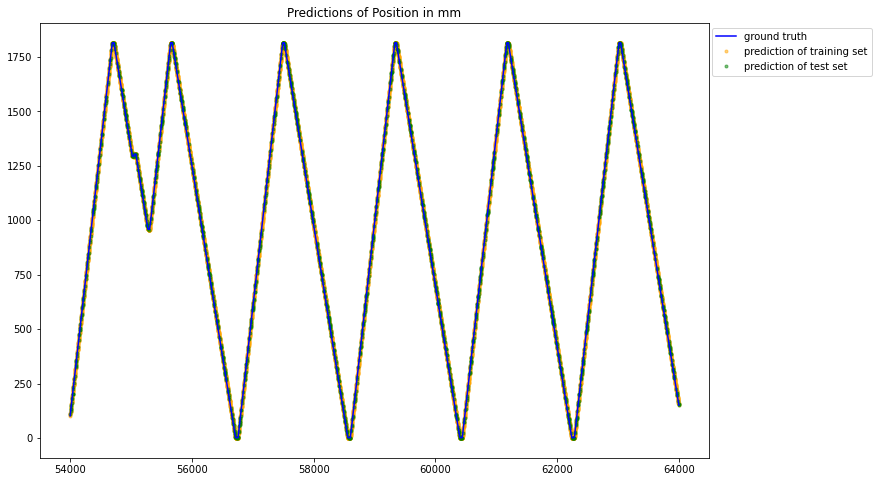

In [31]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## NN with layer norm

### Init

In [32]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
    "ues_ln":True,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_ln.pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
    ues_ln=config.ues_ln,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_ln.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8659


In [33]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [34]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [35]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [36]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.40, test loss : 1030.99, TEST loss : 1026.09, lr: 0.0010
epoch : 10, train loss : 638.57, test loss : 620.88, TEST loss : 615.83, lr: 0.0010
epoch : 20, train loss : 336.75, test loss : 326.48, TEST loss : 321.23, lr: 0.0010
epoch : 30, train loss : 210.41, test loss : 205.79, TEST loss : 200.61, lr: 0.0010
epoch : 40, train loss : 121.78, test loss : 117.86, TEST loss : 113.06, lr: 0.0010
epoch : 50, train loss : 49.75, test loss : 46.69, TEST loss : 42.97, lr: 0.0010
epoch : 60, train loss : 3.21, test loss : 2.52, TEST loss : 4.56, lr: 0.0010
epoch : 70, train loss : 1.47, test loss : 1.31, TEST loss : 3.60, lr: 0.0010
epoch : 80, train loss : 1.31, test loss : 1.41, TEST loss : 3.71, lr: 0.0010
epoch : 90, train loss : 1.19, test loss : 1.10, TEST loss : 3.83, lr: 0.0010
epoch : 100, train loss : 1.12, test loss : 1.08, TEST loss : 3.97, lr: 0.0010
epoch : 110, train loss : 1.04, test loss : 1.63, TEST loss : 4.29, lr: 0.0010
epoch : 120, train loss : 0

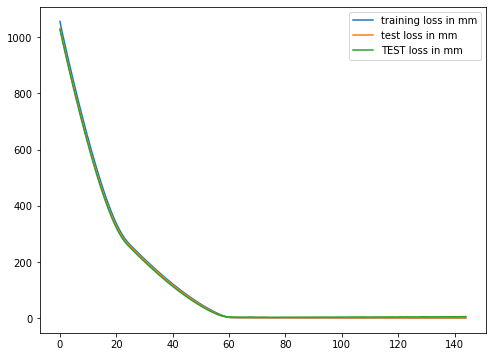

In [37]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [38]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [39]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.76 mm
test RMSE: 0.77 mm
TEST RMSE: 4.54 mm


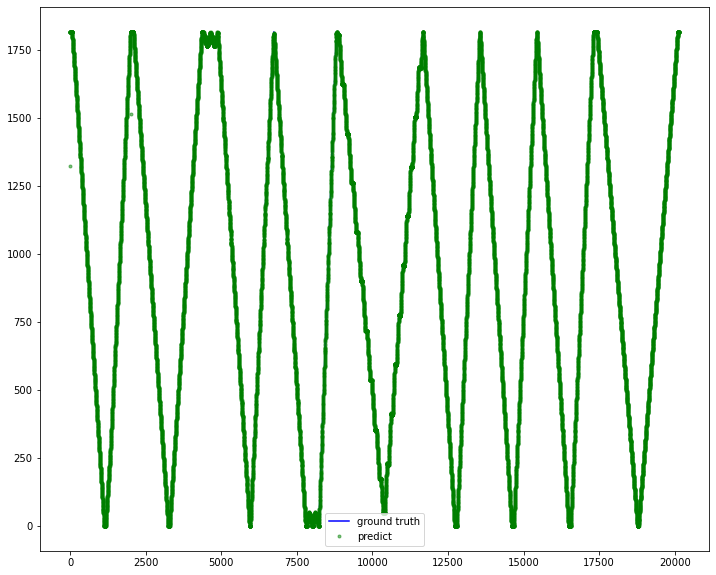

In [40]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


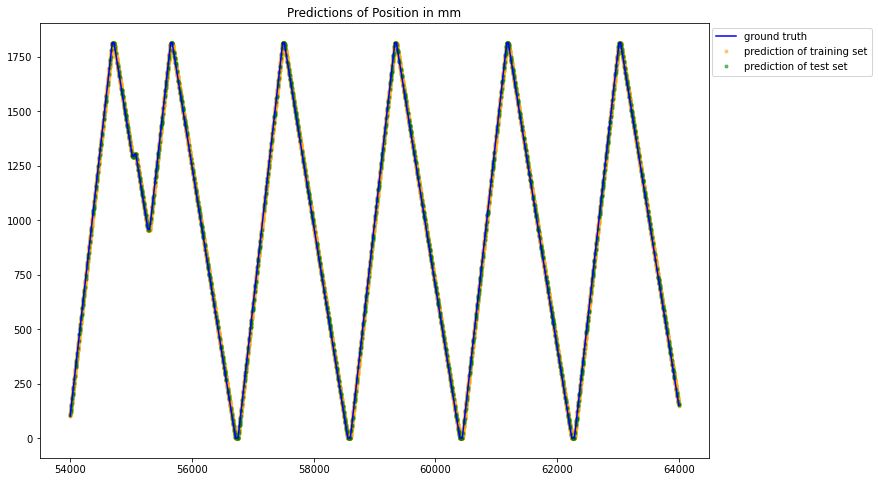

In [41]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 3-layer

### Init

In [42]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": True,
    "ues_ln":False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_ln.pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
    ues_ln=config.ues_ln,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-16_ln.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 9779


In [43]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [44]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [45]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [46]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1054.09, test loss : 1029.86, TEST loss : 1024.98, lr: 0.0010
epoch : 10, train loss : 634.36, test loss : 616.11, TEST loss : 611.48, lr: 0.0010
epoch : 20, train loss : 299.17, test loss : 284.84, TEST loss : 281.17, lr: 0.0010
epoch : 30, train loss : 70.52, test loss : 62.24, TEST loss : 59.27, lr: 0.0010
epoch : 40, train loss : 19.65, test loss : 18.56, TEST loss : 16.12, lr: 0.0010
epoch : 50, train loss : 12.55, test loss : 12.49, TEST loss : 10.82, lr: 0.0010
epoch : 60, train loss : 8.16, test loss : 6.55, TEST loss : 5.51, lr: 0.0010
epoch : 70, train loss : 4.89, test loss : 3.52, TEST loss : 3.15, lr: 0.0010
epoch : 80, train loss : 3.89, test loss : 2.74, TEST loss : 2.72, lr: 0.0010
epoch : 90, train loss : 3.46, test loss : 3.82, TEST loss : 4.01, lr: 0.0010
epoch : 100, train loss : 3.24, test loss : 2.62, TEST loss : 2.79, lr: 0.0010
epoch : 110, train loss : 3.08, test loss : 2.25, TEST loss : 2.51, lr: 0.0010
epoch : 120, train loss : 2.92, t

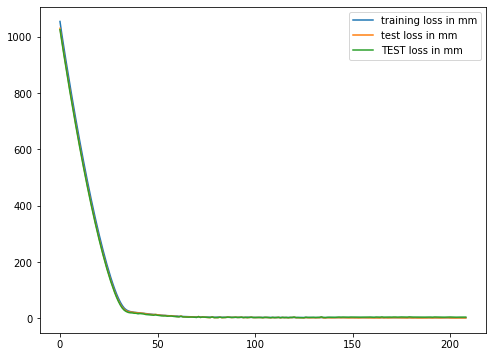

In [47]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [48]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [49]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.26 mm
test RMSE: 1.26 mm
TEST RMSE: 4.04 mm


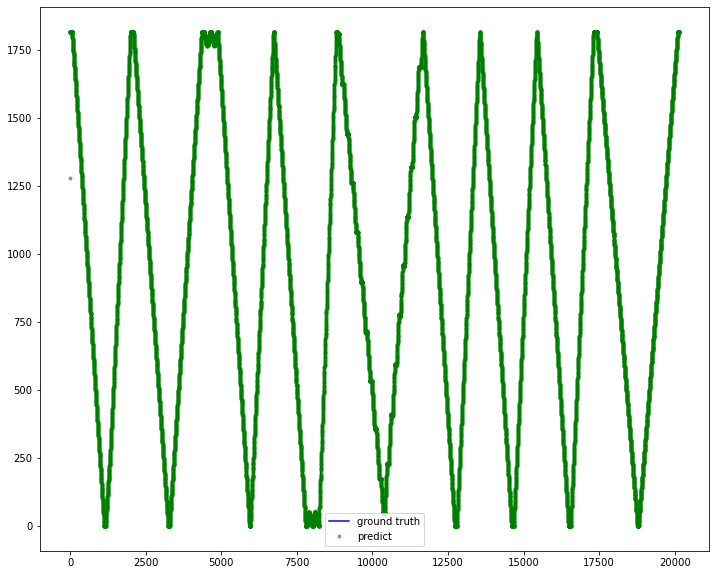

In [50]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


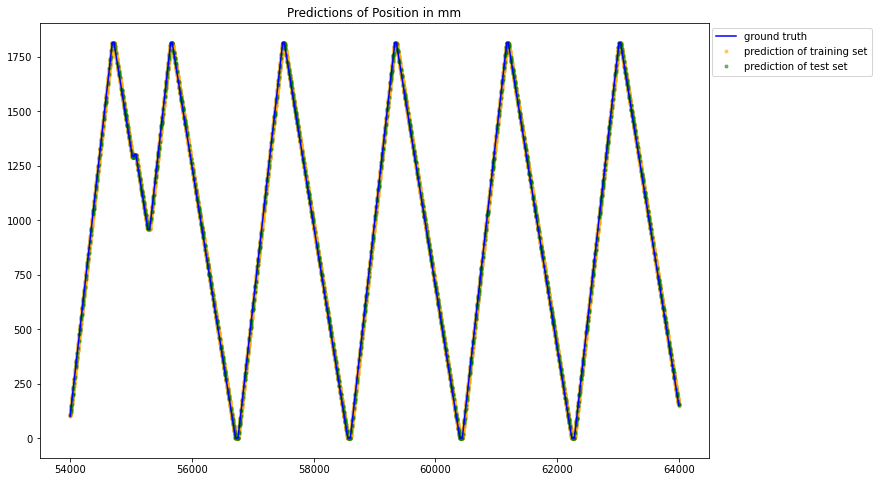

In [51]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 3-layer without bn

### Init

In [52]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
    "ues_ln":False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
    ues_ln=config.ues_ln,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-16.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 9619


In [53]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [54]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [55]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [56]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1054.78, test loss : 1034.20, TEST loss : 1029.31, lr: 0.0010
epoch : 10, train loss : 660.02, test loss : 642.65, TEST loss : 637.98, lr: 0.0010
epoch : 20, train loss : 335.73, test loss : 321.70, TEST loss : 317.99, lr: 0.0010
epoch : 30, train loss : 97.82, test loss : 88.36, TEST loss : 85.97, lr: 0.0010
epoch : 40, train loss : 1.81, test loss : 1.61, TEST loss : 3.12, lr: 0.0010
epoch : 50, train loss : 1.70, test loss : 1.18, TEST loss : 2.66, lr: 0.0010
epoch : 60, train loss : 1.07, test loss : 1.02, TEST loss : 2.26, lr: 0.0010
epoch : 70, train loss : 1.29, test loss : 1.08, TEST loss : 2.18, lr: 0.0010
epoch : 80, train loss : 0.81, test loss : 0.80, TEST loss : 1.92, lr: 0.0010
epoch : 90, train loss : 0.75, test loss : 0.78, TEST loss : 2.32, lr: 0.0010
epoch : 100, train loss : 0.71, test loss : 0.63, TEST loss : 2.08, lr: 0.0010
epoch : 110, train loss : 0.66, test loss : 0.68, TEST loss : 2.97, lr: 0.0010
epoch : 120, train loss : 0.64, test lo

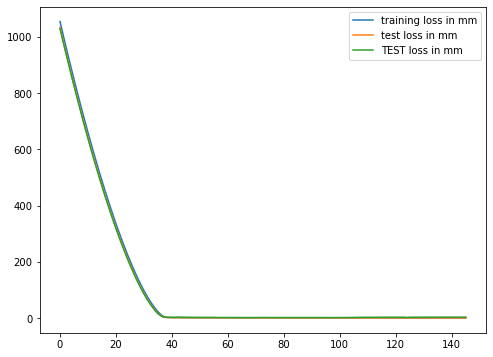

In [57]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [58]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [59]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.53 mm
test RMSE: 0.53 mm
TEST RMSE: 3.30 mm


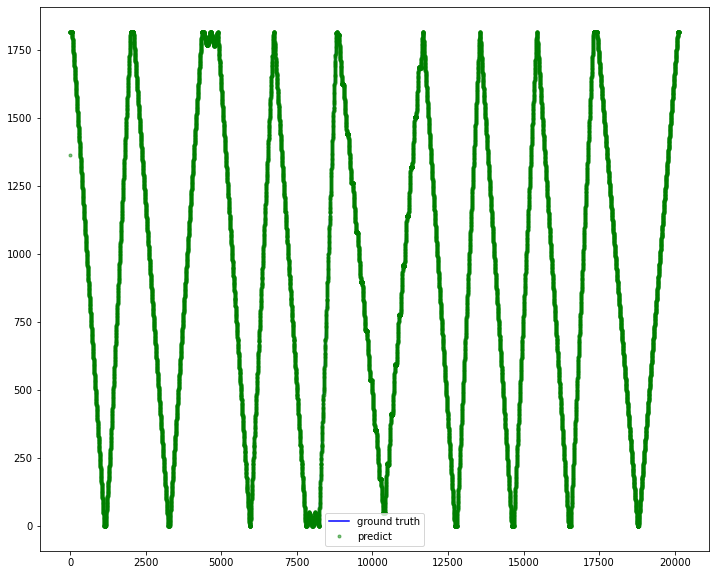

In [60]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


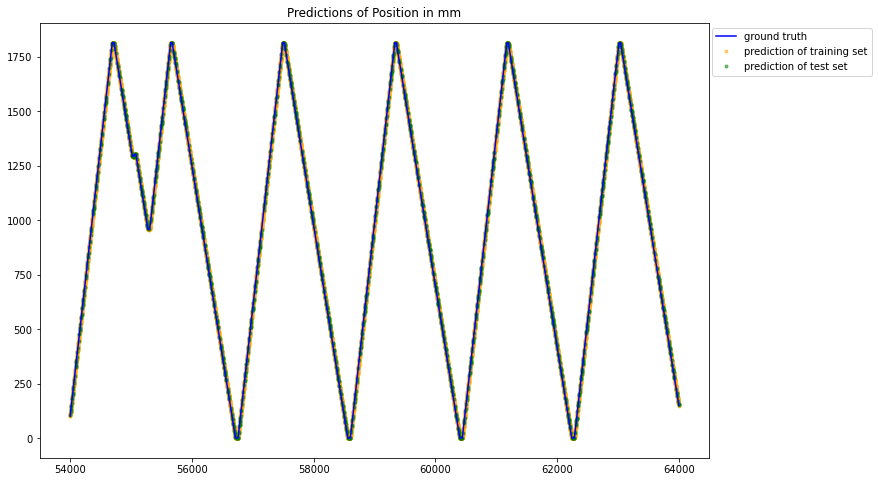

In [61]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 4-layer

### Init

In [86]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": True,
    "ues_ln":False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
    ues_ln=config.ues_ln,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-16.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 10899


In [87]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [88]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [89]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [90]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1054.50, test loss : 1030.60, TEST loss : 1025.73, lr: 0.0010
epoch : 10, train loss : 635.04, test loss : 616.78, TEST loss : 612.15, lr: 0.0010
epoch : 20, train loss : 299.62, test loss : 285.30, TEST loss : 281.66, lr: 0.0010
epoch : 30, train loss : 69.47, test loss : 61.28, TEST loss : 58.43, lr: 0.0010
epoch : 40, train loss : 18.81, test loss : 18.23, TEST loss : 15.80, lr: 0.0010
epoch : 50, train loss : 11.71, test loss : 11.04, TEST loss : 9.17, lr: 0.0010
epoch : 60, train loss : 6.39, test loss : 5.94, TEST loss : 5.03, lr: 0.0010
epoch : 70, train loss : 3.70, test loss : 4.48, TEST loss : 4.45, lr: 0.0010
epoch : 80, train loss : 2.92, test loss : 2.46, TEST loss : 2.58, lr: 0.0010
epoch : 90, train loss : 2.61, test loss : 4.27, TEST loss : 4.35, lr: 0.0010
epoch : 100, train loss : 2.40, test loss : 4.66, TEST loss : 4.70, lr: 0.0010
Early stopping triggered
The minimal test loss is 1.75 from epoch 89


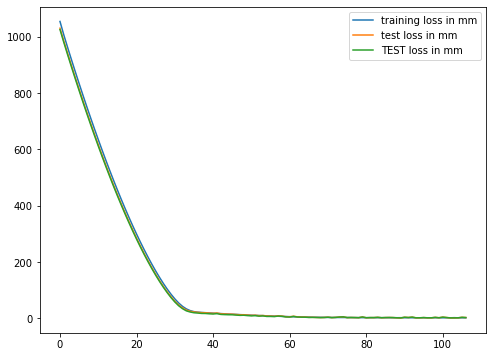

In [91]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [92]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [93]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.77 mm
test RMSE: 1.77 mm
TEST RMSE: 1.96 mm


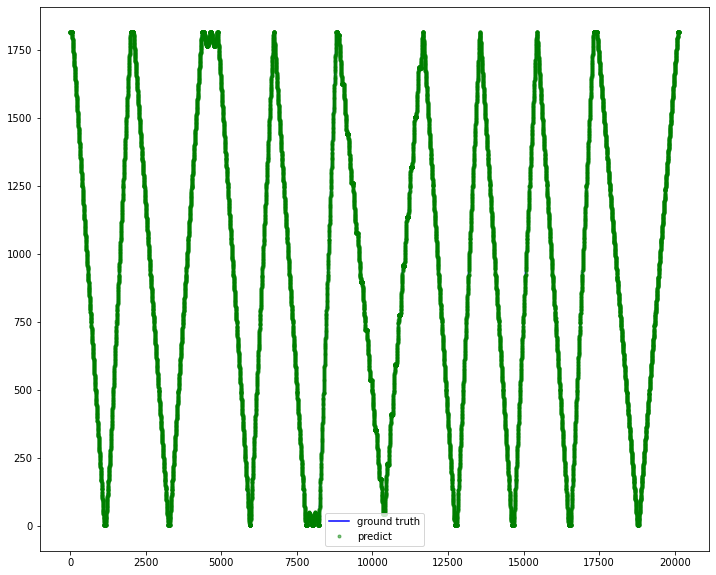

In [94]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


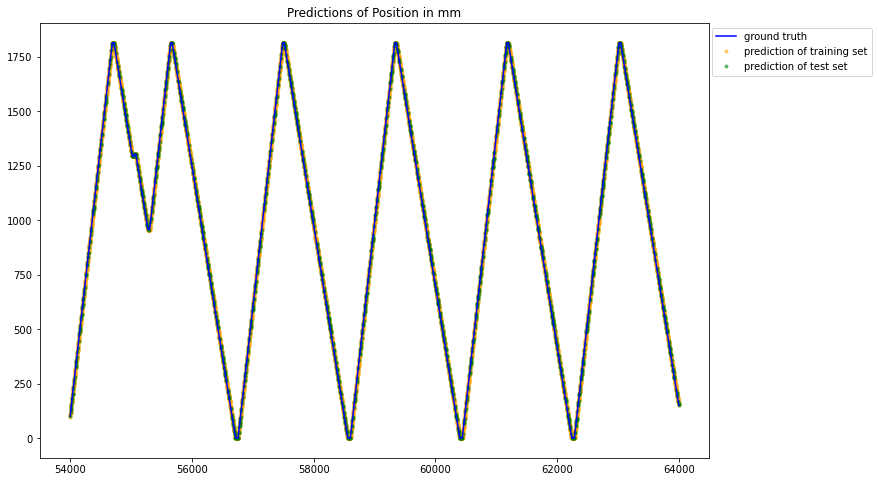

In [95]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 4-layer without bn

### Init

In [96]:
# ocnfiguration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout": False,
    "use_bn": False,
    "ues_ln":False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_fe(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    device=device,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
    ues_ln=config.ues_ln,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-16.pth
NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 10675


In [97]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [98]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [99]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [100]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1061.49, test loss : 1046.27, TEST loss : 1041.38, lr: 0.0010
epoch : 10, train loss : 682.21, test loss : 664.66, TEST loss : 659.95, lr: 0.0010
epoch : 20, train loss : 353.22, test loss : 338.98, TEST loss : 335.19, lr: 0.0010
epoch : 30, train loss : 109.34, test loss : 99.53, TEST loss : 97.04, lr: 0.0010
epoch : 40, train loss : 2.47, test loss : 2.27, TEST loss : 5.92, lr: 0.0010
epoch : 50, train loss : 1.50, test loss : 1.51, TEST loss : 3.54, lr: 0.0010
epoch : 60, train loss : 1.29, test loss : 1.35, TEST loss : 2.44, lr: 0.0010
epoch : 70, train loss : 1.13, test loss : 1.39, TEST loss : 2.15, lr: 0.0010
epoch : 80, train loss : 1.04, test loss : 1.43, TEST loss : 1.91, lr: 0.0010
epoch : 90, train loss : 0.99, test loss : 1.02, TEST loss : 1.58, lr: 0.0010
epoch : 100, train loss : 0.92, test loss : 0.96, TEST loss : 1.49, lr: 0.0010
epoch : 110, train loss : 0.87, test loss : 0.89, TEST loss : 1.19, lr: 0.0010
Early stopping triggered
The minimal t

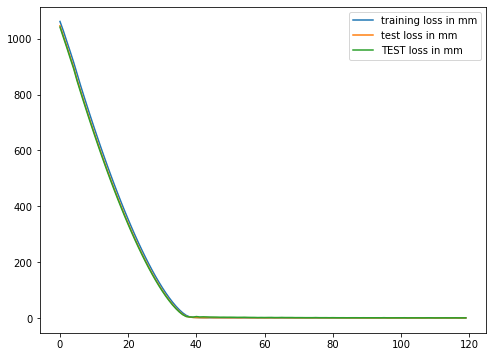

In [101]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [102]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_fe(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [103]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.78 mm
test RMSE: 0.87 mm
TEST RMSE: 1.25 mm


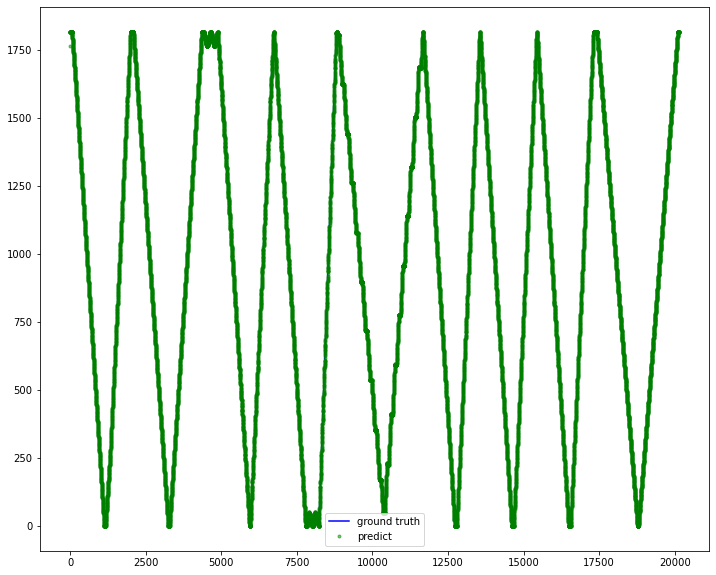

In [104]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


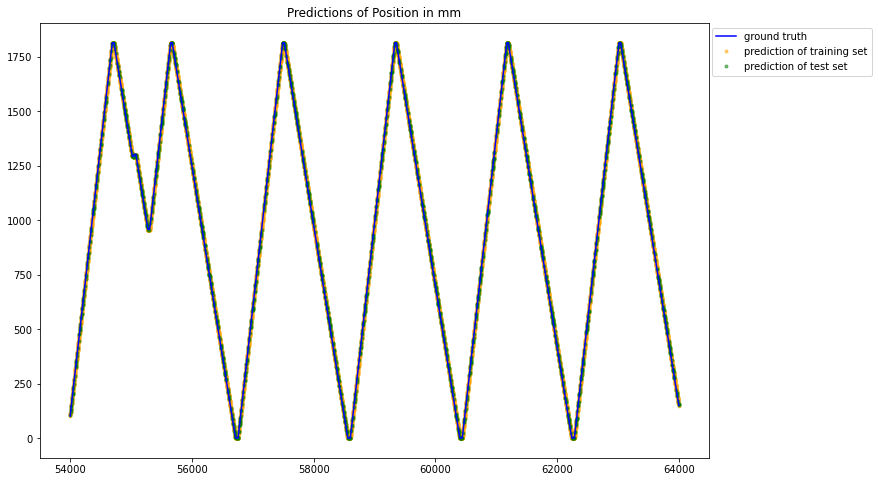

In [105]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
